In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Borra logs anteriores

In [2]:
import shutil

shutil.rmtree('logs', ignore_errors=True)
shutil.rmtree('logs2', ignore_errors=True)

Importa librerías

In [3]:
import tensorflow as tf
assert (tf.__version__=='1.15.4'), 'Versión incorrecta de Tensorflow, por favor instale 1.15.4'
from tensorflow.contrib.layers import flatten
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Dataset 1

Dataset de números del 0 al 9

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Desordena el dataset y lo divide en entrenamiento, validación y prueba.

In [6]:
X_train_, Y_train_ = shuffle(mnist.train.images, mnist.train.labels) 
X_train_orig, X_val_orig, Y_train, Y_val = train_test_split(X_train_, Y_train_, test_size=0.2)

In [7]:
X_train = np.reshape(X_train_orig, (-1, 28, 28))
X_val = np.reshape(X_val_orig, (-1, 28, 28))
X_test = np.reshape(mnist.test.images, (-1, 28, 28))

X_train = np.pad(X_train , ((0,0),(2,2),(2,2)), 'constant')
X_val = np.pad(X_val , ((0,0),(2,2),(2,2)), 'constant')
X_test = np.pad(X_test , ((0,0),(2,2),(2,2)), 'constant')

X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [8]:
Y_test = mnist.test.labels

In [9]:
print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')

X_train: (44000, 32, 32, 1), Y_train: (44000, 10)
X_val: (11000, 32, 32, 1), Y_val: (11000, 10)
X_test: (10000, 32, 32, 1), Y_test: (10000, 10)


Prueba del dataset

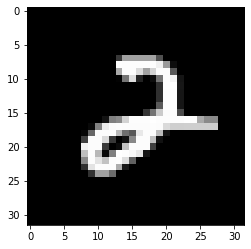

In [10]:
plt.imshow(X_train[15][:,:,0], cmap='gray')

# Lenet

Placeholders:

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None, 10))

Capas ocultas

In [12]:
n_classes = 10
  
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1    

weights = {
    # The shape of the filter weight is (height, width, input_depth, output_depth)
    'conv1': tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma)),
    'conv2': tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma)),
    'fl1': tf.Variable(tf.truncated_normal(shape=(5 * 5 * 16, 120), mean = mu, stddev = sigma)),
    'fl2': tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma)),
    'out': tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
}

biases = {
    # The shape of the filter bias is (output_depth,)
    'conv1': tf.Variable(tf.zeros(6)),
    'conv2': tf.Variable(tf.zeros(16)),
    'fl1': tf.Variable(tf.zeros(120)),
    'fl2': tf.Variable(tf.zeros(84)),
    'out': tf.Variable(tf.zeros(n_classes))
}

# Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
conv1 = tf.nn.conv2d(x, weights['conv1'], strides=[1, 1, 1, 1], padding='VALID')
conv1 = tf.nn.bias_add(conv1, biases['conv1'])
# Activation.
conv1 = tf.nn.relu(conv1)
# Pooling. Input = 28x28x6. Output = 14x14x6.
conv1 = tf.nn.avg_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 2: Convolutional. Output = 10x10x16.
conv2 = tf.nn.conv2d(conv1, weights['conv2'], strides=[1, 1, 1, 1], padding='VALID')
conv2 = tf.nn.bias_add(conv2, biases['conv2'])
# Activation.
conv2 = tf.nn.relu(conv2)
# Pooling. Input = 10x10x16. Output = 5x5x16.
conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Flatten. Input = 5x5x16. Output = 400.
fl0 = flatten(conv2)

# Layer 3: Fully Connected. Input = 400. Output = 120.
fl1 = tf.add(tf.matmul(fl0, weights['fl1']), biases['fl1'])
# Activation.
fl1 = tf.nn.relu(fl1)

# Layer 4: Fully Connected. Input = 120. Output = 84.
fl2 = tf.add(tf.matmul(fl1, weights['fl2']), biases['fl2'])
# Activation.
fl2 = tf.nn.relu(fl2)

# Layer 5: Fully Connected. Input = 84. Output = 10.
logits = tf.add(tf.matmul(fl2, weights['out']), biases['out'])

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Pérdida

In [13]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_operation = tf.reduce_mean(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



Métricas para Tensorboard

In [14]:
summaries = [
    tf.summary.histogram("weights/conv1", weights['conv1']),
    tf.summary.histogram("weights/conv2", weights['conv2']),
    tf.summary.histogram("weights/fl1", weights['fl1']),
    tf.summary.histogram("weights/fl2", weights['fl2']),
    tf.summary.histogram("weights/out", weights['out']),
    tf.summary.histogram("biases/conv1", biases['conv1']),
    tf.summary.histogram("biases/conv2", biases['conv2']),
    tf.summary.histogram("biases/fl1", biases['fl1']),
    tf.summary.histogram("biases/fl2", biases['fl2']),
    tf.summary.histogram("biases/conv1", biases['out']),
    tf.summary.scalar('loss', loss_operation),
]

Cálculo de precisión

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_summary = tf.summary.scalar('accuracy', accuracy_operation)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy, summ = sess.run([accuracy_operation, accuracy_summary], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / num_examples, summ

## Entrenamiento del dataset de 0 a 9

Todas las variables se modifican en la optimización, para el primer entrenamiento:

In [16]:
vars_to_opt = [ weights['conv1'], weights['conv2'], weights['fl1'], weights['fl2'], weights['out'], 
                biases['conv1'], biases['conv2'], biases['fl1'], biases['fl2'], biases['out'] ]

Optimizador

In [17]:
learning_rate = 0.001

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation, var_list=vars_to_opt)

Entrenamiento:

In [18]:
EPOCHS = 10
BATCH_SIZE = 128

saver = tf.train.Saver()

In [19]:
with tf.Session() as session:
    writer = tf.summary.FileWriter("./logs", session.graph)
    
    session.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    step = 0
    
    print("Training LeNet...")
    print()
    for i in range(EPOCHS):
        X_train_epoch, Y_train_epoch = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_epoch[offset:end], Y_train_epoch[offset:end]
            summs = session.run([training_operation]+summaries, feed_dict={x: batch_x, y: batch_y})
            summs.pop(0)
            for summ in summs:
                writer.add_summary(summ, global_step=step)
            step += 1
            
        validation_accuracy, validation_summary = evaluate(X_val, Y_val)
        writer.add_summary(validation_summary, global_step=step)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    writer.close()
    
    saver.save(session, './models/lenet/lenet')
    print("Model saved")

Training LeNet...

EPOCH 1 ...
Validation Accuracy = 0.947

EPOCH 2 ...
Validation Accuracy = 0.968

EPOCH 3 ...
Validation Accuracy = 0.970

EPOCH 4 ...
Validation Accuracy = 0.975

EPOCH 5 ...
Validation Accuracy = 0.979

EPOCH 6 ...
Validation Accuracy = 0.981

EPOCH 7 ...
Validation Accuracy = 0.982

EPOCH 8 ...
Validation Accuracy = 0.984

EPOCH 9 ...
Validation Accuracy = 0.984

EPOCH 10 ...
Validation Accuracy = 0.982

Model saved


## Prueba del dataset de 0 a 9

In [20]:
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('./models/lenet'))

    test_accuracy, _ = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/lenet/lenet
Test Accuracy = 0.984


# Dataset de letras de la A a la J
EMNIST es MNIST extendido, tiene letras.

In [21]:
! pip install emnist

In [22]:
from emnist import extract_training_samples

La primera vez, se demora descargando el dataset (aproximadamente 536MB)

In [23]:
X_orig, Y_orig_idx = extract_training_samples('letters')
A_J_ixd = Y_orig_idx<=10

X_orig = X_orig[A_J_ixd]
X_orig = np.pad(X_orig , ((0,0),(2,2),(2,2)), 'constant')
X_orig = X_orig[..., np.newaxis]
X_orig = X_orig / 255.0

Y_orig_idx = Y_orig_idx[A_J_ixd] - 1
Y_orig = np.zeros((Y_orig_idx.size, Y_orig_idx.max()+1))
Y_orig[np.arange(Y_orig_idx.size),Y_orig_idx] = 1

In [24]:
print(f'X_orig: {X_orig.shape}, Y_orig: {Y_orig.shape}')

X_orig: (48000, 32, 32, 1), Y_orig: (48000, 10)


class: 2


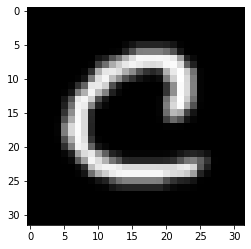

In [25]:
idx = 582
plt.imshow(X_orig[idx][:,:,0], cmap='gray')
print(f'class: {Y_orig_idx[idx]}')

In [26]:
X_orig, Y_orig = shuffle(X_orig, Y_orig) 
X_orig_, X_test, Y_orig_, Y_test = train_test_split(X_orig, Y_orig, test_size=0.2)
X_train, X_val, Y_train, Y_val = train_test_split(X_orig_, Y_orig_, test_size=0.2)

print(f'X_train: {X_train.shape}, Y_train: {Y_train.shape}')
print(f'X_val: {X_val.shape}, Y_val: {Y_val.shape}')
print(f'X_test: {X_test.shape}, Y_test: {Y_test.shape}')

X_train: (30720, 32, 32, 1), Y_train: (30720, 10)
X_val: (7680, 32, 32, 1), Y_val: (7680, 10)
X_test: (9600, 32, 32, 1), Y_test: (9600, 10)


### Probando dataset de letras con entrenamiento de números

In [27]:
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('./models/lenet'))

    test_accuracy, _ = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/lenet/lenet
Test Accuracy = 0.094


### Optimizador para entrenamiento de letras

No se tocan las capas convolucionales, únicamente se modifican las fully connected

In [28]:
vars_to_opt_2 = [ weights['fl1'], weights['fl2'], weights['out'], 
                 biases['fl1'], biases['fl2'], biases['out'] ]

In [29]:
learning_rate = 0.001

optimizer_2 = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation_2 = optimizer_2.minimize(loss_operation, var_list=vars_to_opt_2)

## Entrenamiento para letras de A a J

In [30]:
EPOCHS = 5
BATCH_SIZE = 128

In [31]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver.restore(session, tf.train.latest_checkpoint('./models/lenet'))
    
    writer = tf.summary.FileWriter("./logs2", session.graph)
    
    num_examples = len(X_train)
    
    step = 0
    
    print("Training LeNet 2...")
    print()
    for i in range(EPOCHS):
        X_train_epoch, Y_train_epoch = shuffle(X_train, Y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_epoch[offset:end], Y_train_epoch[offset:end]
            summs = session.run([training_operation_2]+summaries, feed_dict={x: batch_x, y: batch_y})
            summs.pop(0)
            for summ in summs:
                writer.add_summary(summ, global_step=step)
            step += 1
            
        validation_accuracy, validation_summary = evaluate(X_val, Y_val)
        writer.add_summary(validation_summary, global_step=step)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    writer.close()
    
    saver.save(session, './models/lenet2/lenet2')
    print("Model saved")

INFO:tensorflow:Restoring parameters from ./models/lenet/lenet
Training LeNet 2...

EPOCH 1 ...
Validation Accuracy = 0.909

EPOCH 2 ...
Validation Accuracy = 0.940

EPOCH 3 ...
Validation Accuracy = 0.949

EPOCH 4 ...
Validation Accuracy = 0.958

EPOCH 5 ...
Validation Accuracy = 0.958

Model saved


## Prueba para letras de A a J

In [32]:
with tf.Session() as session:
    saver.restore(session, tf.train.latest_checkpoint('./models/lenet2'))

    test_accuracy, _ = evaluate(X_test, Y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./models/lenet2/lenet2
Test Accuracy = 0.954
